In [1]:
import numpy as np
from PIL import Image


def ImgConvolve(image_array, kernel):
    """参数说明：
    image_array：原灰度图像矩阵
    kernel ：卷积核
    返回值: 原图像与算子进行卷积后的结果
    """
    image_arr = image_array.copy()
    img_dim1, img_dim2 = image_arr.shape
    k_dim1, k_dim2 = kernel.shape
    AddW = int((k_dim1 - 1) / 2)
    AddH = int((k_dim2 - 1) / 2)

    # padding填充
    temp = np.zeros([img_dim1 + AddW * 2, img_dim2 + AddH * 2])
    # 将原图拷贝到临时图片的中央
    temp[AddW : AddW + img_dim1, AddH : AddH + img_dim2] = image_arr[:, :]
    # 初始化一张同样大小的图片作为输出图片
    output = np.zeros_like(a=temp)
    # 将扩充后的图和卷积核进行卷积
    for i in range(AddW, AddW + img_dim1):
        for j in range(AddH, AddH + img_dim2):
            output[i][j] = int(
                np.sum(temp[i - AddW : i + AddW + 1, j - AddW : j + AddW + 1] * kernel)
            )

    return output[AddW : AddW + img_dim1, AddH : AddH + img_dim2]


In [2]:
# 提取竖直方向特征
# sobel_x
kernel_1 = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])

# 提取水平方向特征
# sobel_y
kernel_2 = np.array([[-1, -2, -1], [0, 0, 0], [1, 2, 1]])

# Laplace扩展算子
# 二阶微分算子
kernel_3 = np.array([[1, 1, 1], [1, -8, 1], [1, 1, 1]])


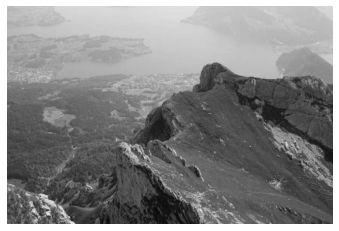

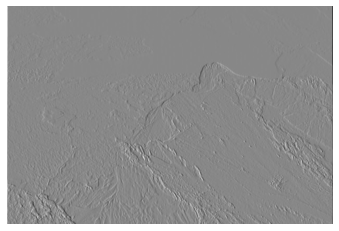

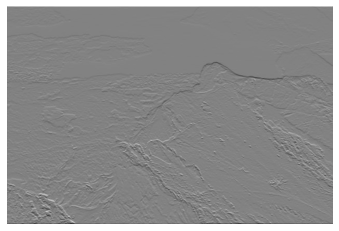

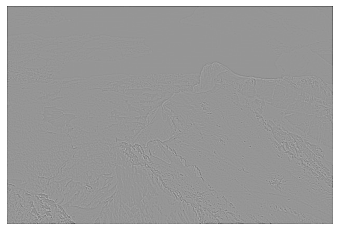

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm

# 打开图像并转化成灰度图像
image = Image.open("./data/mountain.jpg").convert("L")

# 将图像转化成数组
image_array = np.array(image)

# 卷积操作
sobel_x = ImgConvolve(image_array, kernel_1)
sobel_y = ImgConvolve(image_array, kernel_2)
laplace = ImgConvolve(image_array, kernel_3)

# 显示图像


plt.imshow(image_array, cmap=cm.gray)
plt.axis("off")
plt.show()

plt.imshow(sobel_x, cmap=cm.gray)
plt.axis("off")
plt.show()

plt.imshow(sobel_y, cmap=cm.gray)
plt.axis("off")
plt.show()

plt.imshow(laplace, cmap=cm.gray)
plt.axis("off")
plt.show()


In [6]:
import tensorflow as tf
import numpy as np

# tf.nn.conv2d(input, filter, strides, padding, use_cudnn_on_gpu=None, name=None)
input_data = tf.Variable(np.random.rand(10, 9, 9, 4), dtype=np.float32)
filter_data = tf.Variable(np.random.rand(3, 3, 4, 2), dtype=np.float32)
# y = tf.nn.conv2d(input_data, filter_data, strides=[1, 1, 1, 1], padding="SAME")
y = tf.nn.conv2d(input_data, filter_data, strides=[1,1,1,1], padding = 'VALID')

print(input_data)
print(y)


<tf.Variable 'Variable_2:0' shape=(10, 9, 9, 4) dtype=float32_ref>
Tensor("Conv2D_1:0", shape=(10, 7, 7, 2), dtype=float32)


In [7]:
import tensorflow as tf
import numpy as np

input_data = tf.Variable(np.random.rand(10, 6, 6, 4), dtype=np.float32)
filter_data = tf.Variable(np.random.rand(2, 2, 4, 2), dtype=np.float32)
y = tf.nn.conv2d(input_data, filter_data, strides=[1, 1, 1, 1], padding="SAME")

# 最大池化
# tf.nn.max_pool(value, ksize, strides, padding, name=None)
# output = tf.nn.max_pool(value=y,ksize=[1,2,2,1],strides=[1,2,2,1], padding='SAME')

# 平均池化
# tf.nn.avg_pool(value, ksize, strides, padding, name=None)
output = tf.nn.avg_pool(
    value=y, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding="SAME"
)


print("conv:", y)
print("pool_padding_valid:", output)


conv: Tensor("Conv2D_2:0", shape=(10, 6, 6, 2), dtype=float32)
pool_padding_valid: Tensor("AvgPool:0", shape=(10, 3, 3, 2), dtype=float32)


CIFAR-10是由Alex Krizhevsky, Vinod Nair和Geoffrey Hinton收集而来的用于图像识别的数据集，它一共有十个分类，每个分类有6000张32×32大小的彩色图像，所以一共有60000张图像，其中50000张用于训练，10000张用于测试。

## 下载CIFAR-10数据集

In [8]:
import urllib.request
import os
import tarfile

# 下载
url = "https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz"
filepath = "data/cifar-10-python.tar.gz"
if not os.path.isfile(filepath):
    result = urllib.request.urlretrieve(url, filepath)
    print("downloaded:", result)
else:
    print("Data file already exists.")

# 解压
if not os.path.exists("data/cifar-10-batches-py"):
    tfile = tarfile.open("data/cifar-10-python.tar.gz", "r:gz")
    result = tfile.extractall("data/")
    print("Extracted to ./data/cifar-10-batches-py/")
else:
    print("Directory already exists.")


Data file already exists.
Directory already exists.


## 导入CIFAR-10数据集

In [9]:
import os
import numpy as np
import pickle as p


def load_CIFAR_batch(filename):
    """load single batch of cifar"""
    with open(filename, "rb") as f:
        # 一个样本由标签和图像数据组成
        # <1 x label><3072 x pixel> (3072=32x32x3)
        # ...
        # <1 x label><3072 x pixel>
        data_dict = p.load(f, encoding="bytes")
        images = data_dict[b"data"]
        labels = data_dict[b"labels"]

        # 把原始数据结构调整为: BCWH
        images = images.reshape(10000, 3, 32, 32)
        # tensorflow处理图像数据的结构：BWHC
        # 把通道数据C移动到最后一个维度
        images = images.transpose(0, 2, 3, 1)

        labels = np.array(labels)

        return images, labels


def load_CIFAR_data(data_dir):
    """load CIFAR data"""

    images_train = []
    labels_train = []
    for i in range(5):
        f = os.path.join(data_dir, "data_batch_%d" % (i + 1))
        print("loading ", f)
        # 调用 load_CIFAR_batch( )获得批量的图像及其对应的标签
        image_batch, label_batch = load_CIFAR_batch(f)
        images_train.append(image_batch)
        labels_train.append(label_batch)
        Xtrain = np.concatenate(images_train)
        Ytrain = np.concatenate(labels_train)
        del image_batch, label_batch

    Xtest, Ytest = load_CIFAR_batch(os.path.join(data_dir, "test_batch"))
    print("finished loadding CIFAR-10 data")

    # 返回训练集的图像和标签，测试集的图像和标签
    return Xtrain, Ytrain, Xtest, Ytest


data_dir = "data/cifar-10-batches-py/"
Xtrain, Ytrain, Xtest, Ytest = load_CIFAR_data(data_dir)


loading  data/cifar-10-batches-py/data_batch_1
loading  data/cifar-10-batches-py/data_batch_2
loading  data/cifar-10-batches-py/data_batch_3
loading  data/cifar-10-batches-py/data_batch_4
loading  data/cifar-10-batches-py/data_batch_5
finished loadding CIFAR-10 data


## 显示数据集信息

In [10]:
print('training data shape:',Xtrain.shape)
print('training labels shape:',Ytrain.shape)
print('test data shape:',Xtest.shape)
print('test labels shape:',Ytest.shape)

training data shape: (50000, 32, 32, 3)
training labels shape: (50000,)
test data shape: (10000, 32, 32, 3)
test labels shape: (10000,)


## 查看单项image和label

2


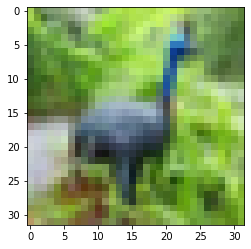

In [11]:
%matplotlib inline
import matplotlib.pyplot as plt

# 查看image
plt.imshow(Xtrain[6])

# 查看label
# 对应类别信息可查看：http://www.cs.toronto.edu/~kriz/cifar.html
print(Ytrain[6])


airplane										
automobile										
bird										
cat										
deer										
dog										
frog										
horse										
ship										
truck

## 查看多项images和label

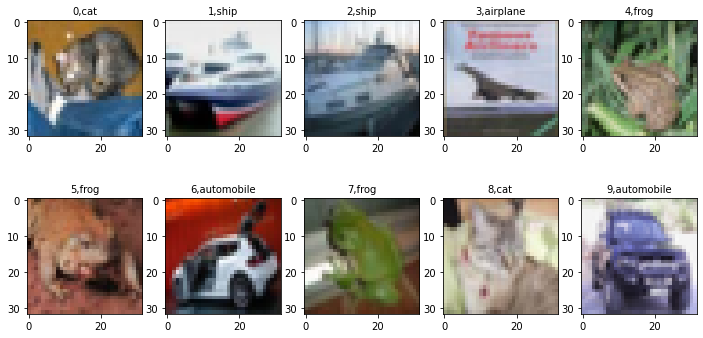

In [25]:
import matplotlib.pyplot as plt

# 定义标签字典，每一个数字所代表的图像类别的名称
label_dict = {
    0: "airplane",
    1: "automobile",
    2: "bird",
    3: "cat",
    4: "deer",
    5: "dog",
    6: "frog",
    7: "horse",
    8: "ship",
    9: "truck",
}


# 定义显示图像数据及其对应标签的函数
def plot_images_labels_prediction(images, labels, prediction, idx, num=10):
    fig = plt.gcf()
    fig.set_size_inches(12, 6)
    if num > 10:
        num = 10
    for i in range(0, num):
        ax = plt.subplot(2, 5, 1 + i)
        ax.imshow(images[idx], cmap="binary")

        title = str(i) + "," + label_dict[labels[idx]]
        if len(prediction) > 0:
            title += "=>" + label_dict[prediction[idx]]

        ax.set_title(title, fontsize=10)

        idx += 1
    plt.show()


# 显示图像数据及其对应标签
plot_images_labels_prediction(Xtest, Ytest, [], 0, 10)


## 数据预处理

In [13]:
# 查看图像数据信息
# 显示第一个图的第一个像素点
Xtrain[0][0][0]

# 将图像进行数字标准化
Xtrain_normalize = Xtrain.astype("float32") / 255.0
Xtest_normalize = Xtest.astype("float32") / 255.0

# 查看预处理后图像数据信息
Xtrain_normalize[0][0][0]


array([0.23137255, 0.24313726, 0.24705882], dtype=float32)

In [26]:
# 查看标签数据
Ytrain[:10]


array([6, 9, 9, 4, 1, 1, 2, 7, 8, 3])

In [27]:
#  独热编码
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder(sparse=False)

yy = [[0], [1], [2], [3], [4], [5], [6], [7], [8], [9]]
encoder.fit(yy)
Ytrain_reshape = Ytrain.reshape(-1, 1)
Ytrain_onehot = encoder.transform(Ytrain_reshape)
Ytest_reshape = Ytest.reshape(-1, 1)
Ytest_onehot = encoder.transform(Ytest_reshape)

# 显示编码后的情况
Ytrain_onehot.shape


(50000, 10)

In [28]:
Ytrain_onehot[:5]

array([[0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [15]:
import tensorflow as tf

tf.reset_default_graph()


## 定义共享函数

In [16]:
# 定义权值
def weight(shape):
    # 在构建模型时，需要使用tf.Variable来创建一个变量
    # 在训练时，这个变量不断更新
    # 使用函数tf.truncated_normal（截断的正态分布）生成标准差为0.1的随机数来初始化权值
    return tf.Variable(tf.truncated_normal(shape, stddev=0.1), name="W")


# 定义偏置
# 初始化为0.1
def bias(shape):
    return tf.Variable(tf.constant(0.1, shape=shape), name="b")


# 定义卷积操作
# 步长为1，padding为'SAME'
def conv2d(x, W):
    # tf.nn.conv2d(input, filter, strides, padding, use_cudnn_on_gpu=None, name=None)
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding="SAME")


# 定义池化操作
# 步长为2，即原尺寸的长和宽各除以2
def max_pool_2x2(x):
    # tf.nn.max_pool(value, ksize, strides, padding, name=None)
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding="SAME")


## 定义网络结构

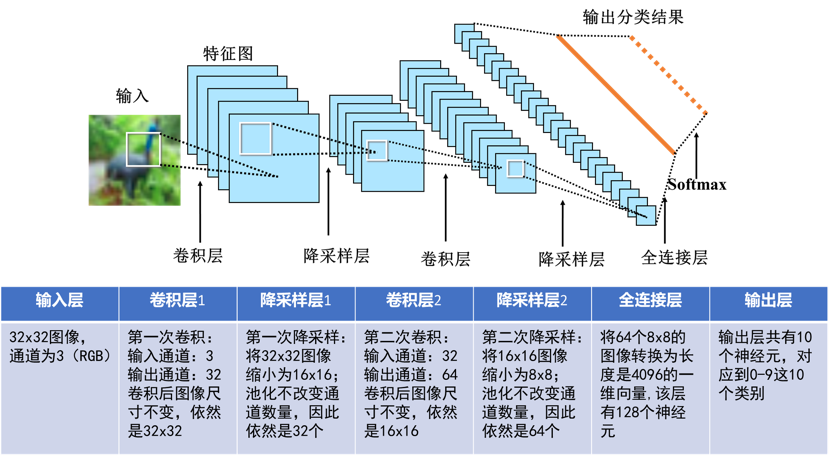

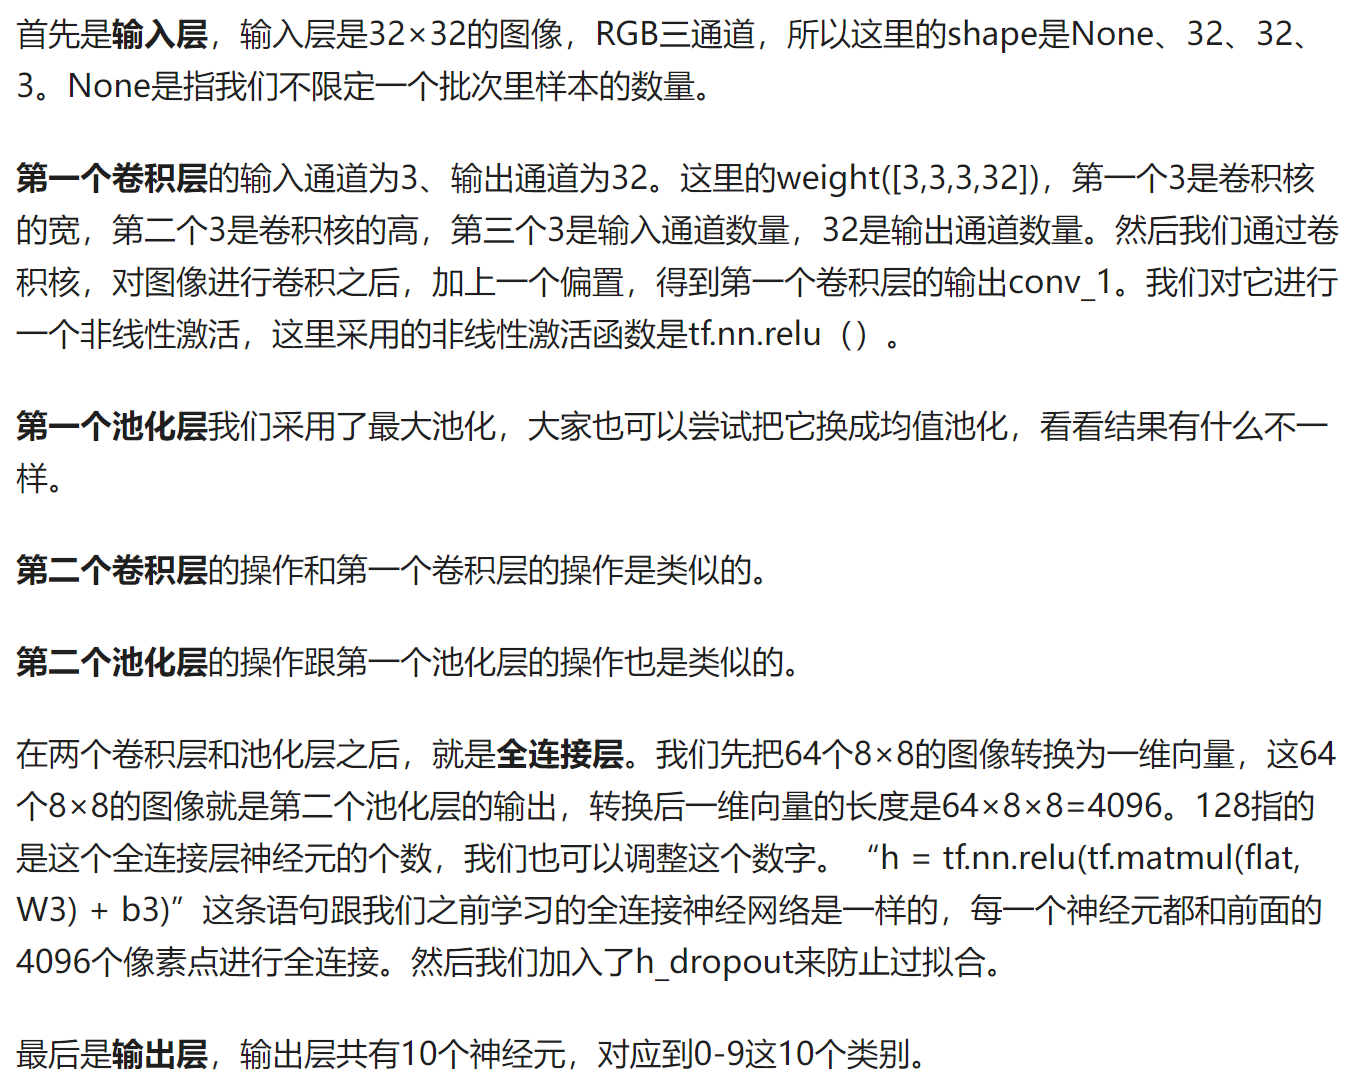

In [17]:
# 输入层
# 32x32图像，通道为3（RGB）
with tf.name_scope("input_layer"):
    x = tf.placeholder("float", shape=[None, 32, 32, 3], name="x")

# 第1个卷积层
# 输入通道：3，输出通道：32，卷积后图像尺寸不变，依然是32x32
with tf.name_scope("conv_1"):
    W1 = weight([3, 3, 3, 32])  # [k_width, k_height, input_chn, output_chn]
    b1 = bias([32])  # 与output_chn 一致
    conv_1 = conv2d(x, W1) + b1
    conv_1 = tf.nn.relu(conv_1)

# 第1个池化层
# 将32x32图像缩小为16x16，池化不改变通道数量，因此依然是32个
with tf.name_scope("pool_1"):
    pool_1 = max_pool_2x2(conv_1)

# 第2个卷积层
# 输入通道：32，输出通道：64，卷积后图像尺寸不变，依然是16x16
with tf.name_scope("conv_2"):
    W2 = weight([3, 3, 32, 64])
    b2 = bias([64])
    conv_2 = conv2d(pool_1, W2) + b2
    conv_2 = tf.nn.relu(conv_2)

# 第2个池化层
# 将16x16图像缩小为8x8，池化不改变通道数量，因此依然是64个
with tf.name_scope("pool_2"):
    pool_2 = max_pool_2x2(conv_2)

# 全连接层
# 将池第2个池化层的64个8x8的图像转换为一维的向量，长度是 64*8*8=4096
# 128个神经元
with tf.name_scope("fc"):
    W3 = weight([4096, 128])  # 有128个神经元
    b3 = bias([128])
    flat = tf.reshape(pool_2, [-1, 4096])
    h = tf.nn.relu(tf.matmul(flat, W3) + b3)
    h_dropout = tf.nn.dropout(h, keep_prob=0.8)

# 输出层
# 输出层共有10个神经元，对应到0-9这10个类别
with tf.name_scope("output_layer"):
    W4 = weight([128, 10])
    b4 = bias([10])
    pred = tf.nn.softmax(tf.matmul(h_dropout, W4) + b4)


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


## 构建模型

In [18]:
with tf.name_scope("optimizer"):
    # 定义占位符
    y = tf.placeholder("float", shape=[None, 10], name="label")
    # 定义损失函数
    loss_function = tf.reduce_mean(
        tf.nn.softmax_cross_entropy_with_logits(logits=pred, labels=y)
    )
    # 选择优化器
    optimizer = tf.train.AdamOptimizer(learning_rate=0.0001).minimize(loss_function)


Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.



In [19]:
with tf.name_scope("evaluation"):
    correct_prediction = tf.equal(tf.argmax(pred, 1), tf.argmax(y, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))


## 训练模型

In [20]:
import os
from time import time

train_epochs = 25
batch_size = 50
total_batch = int(len(Xtrain) / batch_size)
epoch_list = []
accuracy_list = []
loss_list = []
epoch = tf.Variable(0, name="epoch", trainable=False)

startTime = time()

sess = tf.Session()
init = tf.global_variables_initializer()
sess.run(init)


In [29]:
# 设置检查点存储目录
ckpt_dir = "/ckpt_dir/CIFAR10_log/"
if not os.path.exists(ckpt_dir):
    os.makedirs(ckpt_dir)

# 生成saver
saver = tf.train.Saver(max_to_keep=1)

# 如果有检查点文件，读取最新的检查点文件，恢复各种变量值
ckpt = tf.train.latest_checkpoint(ckpt_dir)
if ckpt != None:
    saver.restore(sess, ckpt)  # 加载所有的参数
    # 从这里开始就可以直接使用模型进行预测，或者接着继续训练了
else:
    print("Training from scratch.")

# 获取续训参数
start = sess.run(epoch)
print("Training starts form {} epoch.".format(start + 1))


Training from scratch.
Training starts form 26 epoch.


In [30]:
def get_train_batch(number, batch_size):
    return Xtrain_normalize[
        number * batch_size : (number + 1) * batch_size
    ], Ytrain_onehot[number * batch_size : (number + 1) * batch_size]


for ep in range(start, train_epochs):
    for i in range(total_batch):
        batch_x, batch_y = get_train_batch(i, batch_size)  # 读取批次数据
        sess.run(optimizer, feed_dict={x: batch_x, y: batch_y})  # 执行批次训练

        if i % 100 == 0:
            print("Step {}".format(i), "finished")

    # total_batch个批次训练完成后 使用验证数据计算误差与准确率
    loss, acc = sess.run([loss_function, accuracy], feed_dict={x: batch_x, y: batch_y})
    epoch_list.append(ep + 1)
    loss_list.append(loss)
    accuracy_list.append(acc)

    # 打印训练过程中的详细信息
    print(
        "Train Epoch:",
        "%02d" % (sess.run(epoch) + 1),
        "Loss = ",
        "{:.6f}".format(loss),
        "Accuracy = ",
        acc,
    )

    # 保存检查点
    saver.save(sess, ckpt_dir + "CIFAR10_cnn_model.cpkt", global_step=ep + 1)
    sess.run(epoch.assign(ep + 1))

# 显示运行总时间
duration = time() - startTime
print("Train Finished takes : ", duration)


Train Finished takes :  10152.756619930267


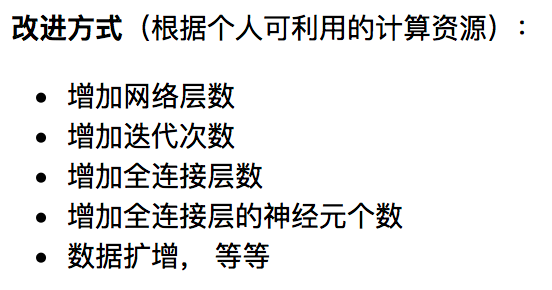

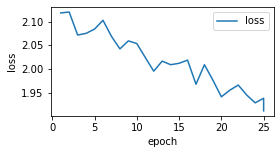

In [31]:
%matplotlib inline
import matplotlib.pyplot as plt

fig = plt.gcf()
fig.set_size_inches(4, 2)
plt.plot(epoch_list, loss_list, label="loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["loss"], loc="upper right")


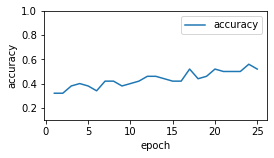

In [32]:
plt.plot(epoch_list, accuracy_list,label="accuracy" )
fig = plt.gcf()
fig.set_size_inches(4,2)
plt.ylim(0.1,1)
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend()
plt.show()

## 评估模型及预测

In [33]:
test_total_batch = int(len(Xtest_normalize)/batch_size)
test_acc_sum = 0.0
for i in range(test_total_batch):
    test_image_batch = Xtest_normalize[i*batch_size:(i+1)*batch_size]
    test_label_batch = Ytest_onehot[i*batch_size:(i+1)*batch_size]
    test_batch_acc = sess.run(accuracy, feed_dict = {x:test_image_batch,y:test_label_batch})
    test_acc_sum += test_batch_acc
test_acc = float(test_acc_sum/test_total_batch)
print("Test accuracy:{:.6f}".format(test_acc))

Test accuracy:0.610700


In [34]:
test_pred=sess.run(pred, feed_dict={x: Xtest_normalize[:10]})
prediction_result = sess.run(tf.argmax(test_pred,1))

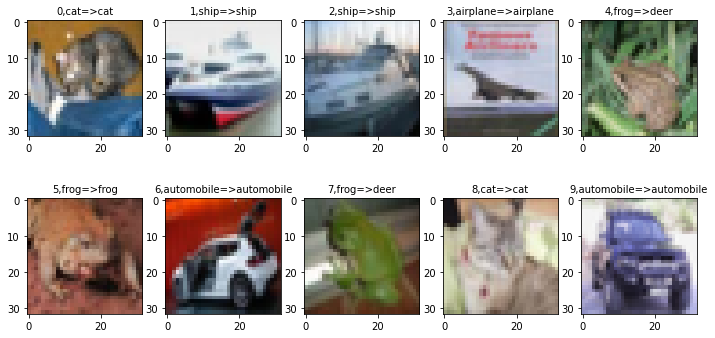

In [35]:
plot_images_labels_prediction(Xtest,Ytest,prediction_result,0,10)